In [ ]:
!pip install catboost

In [ ]:
!pip install git+https://github.com/gmihaila/ml_things

In [98]:
import os
import json
import jsonlines
import re

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from ml_things import plot_confusion_matrix
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Open training data

In [46]:
train = pd.DataFrame()
val = pd.DataFrame()
test = pd.DataFrame()

In [47]:
for folder in os.listdir('data/'):
    if folder[:3] != 'df_' or folder[-3:] == 'zip':
        continue
    
    train_temp = pd.read_csv(f'data/{folder}/train.csv')
    val_temp = pd.read_csv(f'data/{folder}/val.csv')
    test_temp = pd.read_csv(f'data/{folder}/test.csv')
    
    train[folder[3:]] = train_temp.pred
    val[folder[3:]] = val_temp.pred
    test[folder[3:]] = test_temp.pred
    
train['labels'] = train_temp.labels
val['labels'] = val_temp.labels
test['labels'] = test_temp.labels

# Add cosine-similarity

In [95]:
!curl https://raw.githubusercontent.com/AI-Front/NTI/main/semifinals/data/train.jsonl -o data/train.jsonl
!curl https://raw.githubusercontent.com/AI-Front/NTI/main/semifinals/data/val.jsonl -o data/val.jsonl
!curl https://raw.githubusercontent.com/AI-Front/NTI/main/semifinals/data/test.jsonl -o data/test.jsonl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2861k  100 2861k    0     0  1301k      0  0:00:02  0:00:02 --:--:-- 1300k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  553k  100  553k    0     0   481k      0  0:00:01  0:00:01 --:--:--  481k1  354k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1698k  100 1698k    0     0   882k      0  0:00:01  0:00:01 --:--:--  882k


In [110]:
def get_cosine(path):
    """
    Args:
        path (string): Path to jsonl file
    """
    data = []
    with open(path, 'r') as json_file:
        json_list = list(json_file)
        for json_str in json_list:
            item = json.loads(json_str)
            text = re.sub(r'\(\d+\)', "", item['passage']['text']).replace('"', '')
            questions = item['passage']['questions']
            for q in questions:
                question = q['question']
                ans = q['answers']
                ans_texts = []
                for a in ans:
                    ans_texts.append(a["text"])
                tfidf = TfidfVectorizer(token_pattern=r'(?u)\b[\wА-Яа-я]+\b')
                print(ans_texts)
                mx_tf = tfidf.fit_transform(ans_texts)
                new_entry = tfidf.transform([text])
                cosine_similarities = linear_kernel(new_entry, mx_tf).flatten()
                data.extend(cosine_similarities)
    return data

In [112]:
train['cosine'] = get_cosine('data/train.jsonl')
val['cosine'] = get_cosine('data/val.jsonl')
test['cosine'] = get_cosine('data/test.jsonl')

['В парке.', 'В лесу.', 'Около подъезда.']
['Он к ней приставал.', 'Он ее оскорбил.', 'Машинка случайно упала.']
['Бегали в библиотеку и обратно.', 'Пили, картёжничали, дрались и снимали девок.', 'Выгуливали собак.', 'Учились.', 'Развлекались игрой в карты, пьянкой, драками, снимали они тут и девок.']
['Артёмка приставал к ней.', 'Они играли.', 'Она его подстригала и они прощались до следующего раза.', 'Артёмка начинал хватать её за разные места.', 'Артёмка тут же обрастал снова.']
['Рыжие.', 'Кудри.', 'Ломкие.', 'Прямые.', 'Вьющиеся.']
['Слипшиеся макароны.', 'Рожки из заводской столовой.', 'Железобетонные скамейки.', 'Деревянные скамейки.', 'Разные места.']
['Ели липкие рожки.', 'Стригли Артемку.', 'Играли в карты.', 'Играли в ножницы и расчёску.', 'Пили и дрались.']
['Парень со вспененной белой головой.', 'Предводитель местной шпаны.', 'Ребятишки, которые бегали в парке.', 'Железобетонные лавочки.', 'Девки.']
['Домогаться до Людочки.', 'Приставать к Людочке.', 'Ломать деревянные ска

# Result dfs

In [1]:
train

NameError: name 'train' is not defined

In [114]:
val

,distilbert-base-multilingual-cased,bert-base-multilingual-cased,sentence-RuBERT,RuBERT,bert-base-multilingual-uncased,bert-base-multilingual-cased 3,bert-base-multilingual-cased 2,albert-base-v2,labels,cosine
0,1,1,1,1,0,1,1,0,1,0.136374
1,0,1,0,0,0,0,0,0,0,0.000000
2,0,0,0,0,0,0,0,1,0,0.016025
3,1,1,1,1,1,1,1,1,0,0.573290
4,1,1,1,1,1,1,1,1,1,0.280958
...,...,...,...,...,...,...,...,...,...,...
2230,0,0,0,1,0,0,1,0,0,0.000000
2231,0,0,0,0,0,0,0,0,0,0.536532
2232,1,1,1,1,1,1,1,0,1,0.329171
2233,1,1,1,1,1,1,1,0,1,0.630668


In [115]:
test

,distilbert-base-multilingual-cased,bert-base-multilingual-cased,sentence-RuBERT,RuBERT,bert-base-multilingual-uncased,bert-base-multilingual-cased 3,bert-base-multilingual-cased 2,albert-base-v2,labels,cosine
0,0,0,0,0,0,0,0,0,NaN,0.230031
1,1,0,0,0,0,0,0,0,NaN,0.228176
2,0,0,1,0,1,1,0,1,NaN,0.101422
3,1,1,1,1,1,1,1,1,NaN,0.677743
4,0,0,0,0,0,0,0,0,NaN,0.077401
...,...,...,...,...,...,...,...,...,...,...
7609,0,1,0,0,1,1,1,0,NaN,0.524918
7610,0,0,0,0,0,0,0,0,NaN,0.221333
7611,0,0,0,0,0,0,0,0,NaN,0.000000
7612,0,0,0,0,0,0,0,0,NaN,0.221333


# Modeling

## Setup model

In [135]:
model = RandomForestClassifier(
                                n_estimators=1000,
                                class_weight={0: 45, 1: 55},
                                random_state=179,
                                n_jobs =-1,
                                verbose=2
                              )

## Train model

In [136]:
model.fit(train.drop(['labels'], axis=1), train.labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.1s


building tree 1 of 1000building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000

building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000building tree 8 of 1000

building tree 9 of 1000
building tree 10 of 1000building tree 11 of 1000

building tree 12 of 1000
building tree 13 of 1000building tree 14 of 1000
building tree 15 of 1000

building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000building tree 23 of 1000

building tree 24 of 1000
building tree 25 of 1000building tree 26 of 1000

building tree 27 of 1000building tree 28 of 1000

building tree 29 of 1000building tree 30 of 1000

building tree 31 of 1000building tree 32 of 1000

building tree 33 of 1000building tree 34 of 1000

building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    0.5s


building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tree 196 of 1000
building tree 197 of 1000
building tree 198 of 1000
building tree 199 of 1000
building tree 200 of 1000building tree 201 of 1000

building tree 202 of 1000
building tree 203 of 1000
building tree 204 of 1000
building tree 205 of 1000
building tree 206 of 1000
building tree 207 of 1000building tree 208 of 1000
building tree 209 of 1000
building tree 210 of 1000

building tree 211 of 1000
building tree 212 of 1000building tree 213 of 1000building tree 214 of 1000


building tree 215 of 1000building tree 216 of 1000

building tree 217 of 1000building tree 218 of 1000

building tree 219 of 1000
building tree 220 of 1000
building tree 221 of 1000
building tree 222 of 1000
building tree 223 of 1000
building tree 224 of 1000
building tree 225 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    1.2s


building tree 372 of 1000
building tree 373 of 1000building tree 374 of 1000

building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000building tree 379 of 1000

building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000building tree 384 of 1000

building tree 385 of 1000
building tree 386 of 1000building tree 387 of 1000

building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tree 399 of 1000building tree 400 of 1000
building tree 401 of 1000

building tree 402 of 1000
building tree 403 of 1000
building tree 404 of 1000building tree 405 of 1000

building tree 406 of 1000
building tree 407 of 1000building tree 408 of 1000
building tree 409 of 1000

building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:    2.2s


building tree 677 of 1000building tree 678 of 1000

building tree 679 of 1000building tree 680 of 1000

building tree 681 of 1000building tree 682 of 1000building tree 683 of 1000


building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000building tree 687 of 1000

building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000building tree 691 of 1000building tree 692 of 1000


building tree 693 of 1000
building tree 694 of 1000
building tree 695 of 1000
building tree 696 of 1000
building tree 697 of 1000
building tree 698 of 1000
building tree 699 of 1000
building tree 700 of 1000
building tree 701 of 1000
building tree 702 of 1000building tree 703 of 1000building tree 704 of 1000


building tree 705 of 1000
building tree 706 of 1000building tree 707 of 1000

building tree 708 of 1000
building tree 709 of 1000
building tree 710 of 1000building tree 711 of 1000building tree 712 of 1000


building tree 713 of 1000
building tree 714 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


RandomForestClassifier(class_weight={0: 45, 1: 55}, n_estimators=1000,
                       n_jobs=-1, random_state=179, verbose=2)

## Validate on val_df

In [137]:
val_pred = model.predict(val.drop(['labels'], axis=1))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [138]:
print("Precision: {0:6.4f}".format(precision_score(val.labels, val_pred, average='macro', zero_division=0)))
print("Recall: {0:6.4f}".format(recall_score(val.labels, val_pred, average='macro', zero_division=0)))
print("F1-measure: {0:6.4f}".format(f1_score(val.labels, val_pred, average='macro', zero_division=0)))
print("Accuracy: {0:6.4f}".format(accuracy_score(val.labels, val_pred)))
print()
print(classification_report(val.labels, val_pred, zero_division=0))

Precision: 0.7661
Recall: 0.7603
F1-measure: 0.7621
Accuracy: 0.7673

              precision    recall  f1-score   support

           0       0.77      0.82      0.80      1242
           1       0.76      0.70      0.73       993

    accuracy                           0.77      2235
   macro avg       0.77      0.76      0.76      2235
weighted avg       0.77      0.77      0.77      2235



Normalized confusion matrix


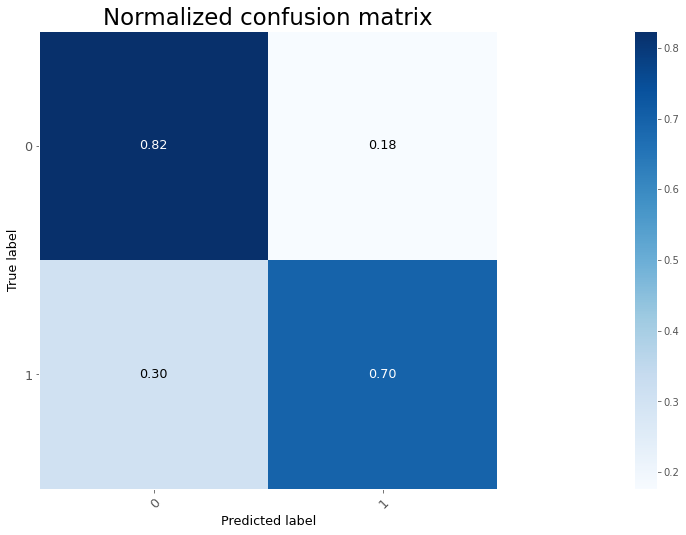

array([[0.8236715 , 0.1763285 ],
       [0.30312185, 0.69687815]])

In [139]:
plot_confusion_matrix(y_true=val.labels, y_pred=val_pred, magnify=.15, normalize=True)

## Predict test_df

In [140]:
pred = model.predict(test.drop(['labels'], axis=1))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [141]:
Counter(pred)

Counter({0: 4606, 1: 3008})

# Make submition

In [123]:
def save_pred(filename, preds, model):
    with open('data/test.jsonl', 'r') as json_file:
        test = list(map(lambda x: json.loads(x), list(json_file)))
    ind = 0
    for i in range(len(test)):
        test[i]['passage'].pop("text")
        questions = test[i]['passage']['questions']
        for j in range(len(questions)):
            questions[j].pop("question")
            for k in range(len(questions[j]["answers"])):
                questions[j]["answers"][k] = {"idx": questions[j]["answers"][k]['idx'],
                                              "label": int(preds[ind])}
                ind += 1
    
    !mkdir submitions/
    
    with jsonlines.open("submitions/" + filename, 'w') as file:
        file.write_all(test)
    with open('submitions/info.txt', 'a') as file:
        file.write(f"- File: {filename}\nModel: {model}\n\n\n")

In [124]:
file_name = f'{__import__("datetime").datetime.now()}.jsonl'
save_pred(file_name, pred, str(model))

mkdir: submitions/: File exists
